In [1]:
import os

import yaml
from PIL import Image
import torch
import numpy as np

from modules import *
from visprog import ProgramRunner

/home/ahmadsa/anaconda3/envs/visprog/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/ahmadsa/anaconda3/envs/visprog/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
colorpop = ColorPop()
count = Count()
emoji = Emoji()
eval_ = Eval()
facedet = FaceDet(device='cpu')
loc = Loc(device='cpu', threshold=0.08)
replace = Replace(device='cuda:1' if torch.cuda.is_available() else 'cpu')
result_ = Result()
seg = Seg(device='cpu')
select = Select(seg.model.config.id2label, seg.model.config.label2id, device='cpu')
vqa = VQA(device='cpu', cast_from_string=True)

/home/ahmadsa/anaconda3/envs/visprog/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmadsa/anaconda3/envs/visprog/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [4]:
modules = [colorpop, count, emoji, eval_, facedet, loc, replace, result_, seg, select, vqa]

In [5]:
program_runner = ProgramRunner(modules)

In [6]:
def do_imgedit_or_gqa(image: Image, program: str):
  initial_state = {
    'IMAGE': image,
  }
  steps, result = program_runner.execute_program(program, initial_state)
  return steps, result

def do_nlvr(left_image: Image, right_image: Image, program: str):
  initial_state = {
    'LEFT': left_image,
    'RIGHT': right_image,
  }
  steps, result = program_runner.execute_program(program, initial_state)
  return steps, result

In [7]:
with open('assets/fig1/imgedit_prompts.yaml', 'r') as f:
  prompts = yaml.safe_load(f)

In [8]:
images_dir = 'assets/fig1'

Hide Daniel Craig with 8) and Sean Connery with ;)


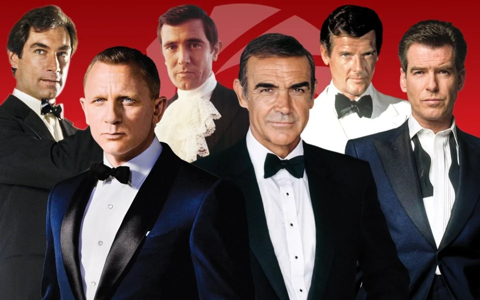

In [9]:
prompt = prompts[0]
instruction = prompt['prompt']['instruction']
image = Image.open(os.path.join(images_dir, prompt['image'])).convert('RGB')
print(instruction)
image.resize((image.size[0] // 2, image.size[1] // 2))

OBJ0 = FACEDET(image=IMAGE)
OBJ1 = SELECT(image=IMAGE, object=OBJ0, query='Daniel Craig', category=None)
IMAGE0 = EMOJI(image=IMAGE, object=OBJ1, emoji='smiling_face_with_sunglasses')
OBJ2 = SELECT(image=IMAGE, object=OBJ0, query='Sean Connery', category=None)
IMAGE1 = EMOJI(image=IMAGE0, object=OBJ2, emoji='winking_face')
FINAL_RESULT = RESULT(var=IMAGE1)


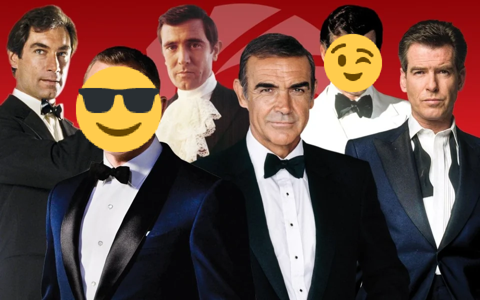

In [11]:
program = prompt['programs'][0]
print(program)
steps, result = do_imgedit_or_gqa(image, program)
result.output['var'].resize((image.size[0] // 2, image.size[1] // 2))

In [12]:
result.output['var'].save(os.path.join(images_dir, f'{prompt["id"]}_result0.png'))

OBJ0 = FACEDET(image=IMAGE)


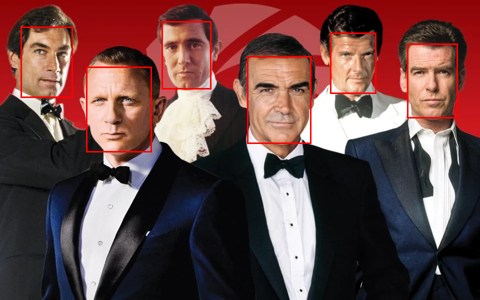

In [14]:
print(steps[0])
result.step_details[0]['image_with_bbox'].resize((image.size[0] // 2, image.size[1] // 2))

OBJ1 = SELECT(image=IMAGE, object=OBJ0, query='Daniel Craig', category=None)


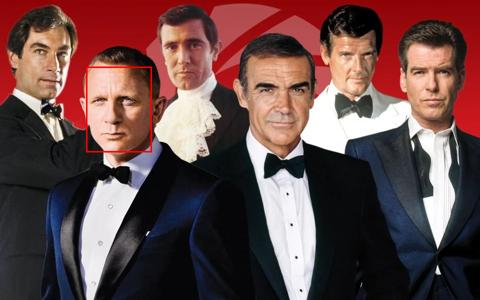

In [15]:
print(steps[1])
result.step_details[1]['output'].resize((image.size[0] // 2, image.size[1] // 2))

IMAGE0 = EMOJI(image=IMAGE, object=OBJ1, emoji='smiling_face_with_sunglasses')


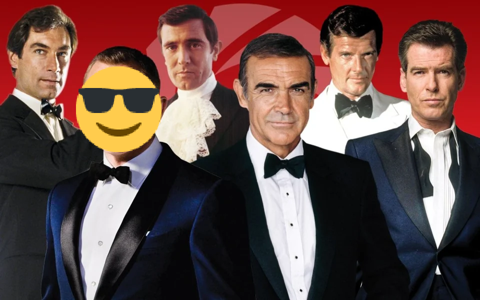

In [16]:
print(steps[2])
result.step_details[2]['output'].resize((image.size[0] // 2, image.size[1] // 2))

OBJ2 = SELECT(image=IMAGE, object=OBJ0, query='Sean Connery', category=None)


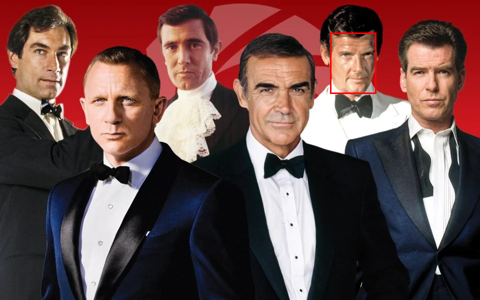

In [17]:
print(steps[3])
result.step_details[3]['output'].resize((image.size[0] // 2, image.size[1] // 2))

IMAGE1 = EMOJI(image=IMAGE0, object=OBJ2, emoji='winking_face')


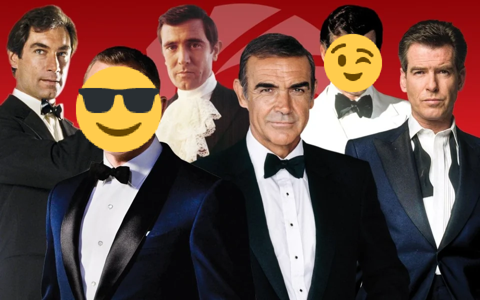

In [18]:
print(steps[4])
result.step_details[4]['output'].resize((image.size[0] // 2, image.size[1] // 2))

Replace desert with green grass


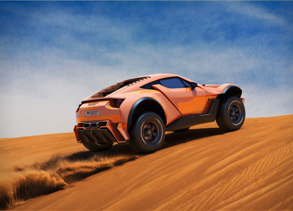

In [19]:
prompt = prompts[1]
instruction = prompt['prompt']['instruction']
image = Image.open(os.path.join(images_dir, prompt['image'])).convert('RGB')
print(instruction)
image.resize((image.size[0] // 2, image.size[1] // 2))

OBJ0 = SEG(image=IMAGE)
OBJ1 = SELECT(image=IMAGE, object=OBJ0, query='desert', category=None)
IMAGE0 = REPLACE(image=IMAGE, object=OBJ1, prompt='green grass')
FINAL_RESULT = RESULT(var=IMAGE0)


  0%|          | 0/50 [00:00<?, ?it/s]

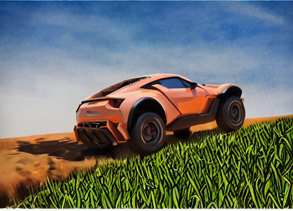

In [29]:
program = prompt['programs'][0]
print(program)
steps, result = do_imgedit_or_gqa(image, program)
result.output['var'].resize((image.size[0] // 2, image.size[1] // 2))

In [30]:
result.output['var'].save(os.path.join(images_dir, f'{prompt["id"]}_result0.png'))

'OBJ0 = SEG(image=IMAGE)'

'sky'

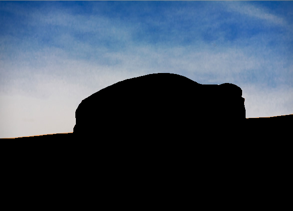

'earth, ground'

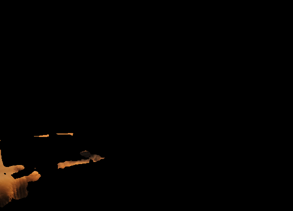

'car'

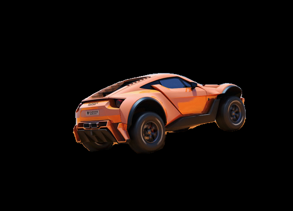

'dirt track'

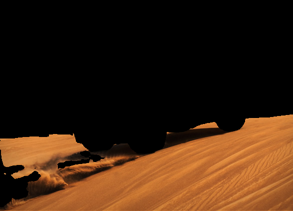

In [31]:
labels = [select.category_id_to_name[x] for x in np.unique(result.state['OBJ0'])]
display(steps[0], *sum([[label, i.resize((image.size[0] // 2, image.size[1] // 2))] for label, i in zip(labels, result.step_details[0]['output'])], []))

OBJ1 = SELECT(image=IMAGE, object=OBJ0, query='desert', category=None)


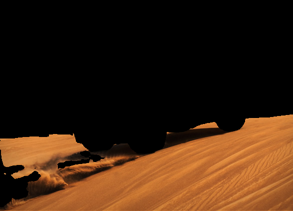

In [32]:
print(steps[1])
result.step_details[1]['output'].resize((image.size[0] // 2, image.size[1] // 2))

IMAGE0 = REPLACE(image=IMAGE, object=OBJ1, prompt='green grass')


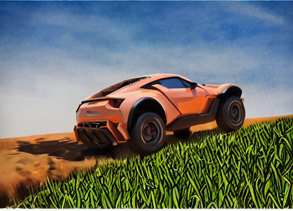

In [33]:
print(steps[2])
result.step_details[2]['output'].resize((image.size[0] // 2, image.size[1] // 2))

Create a color pop of Barack Obama (person)


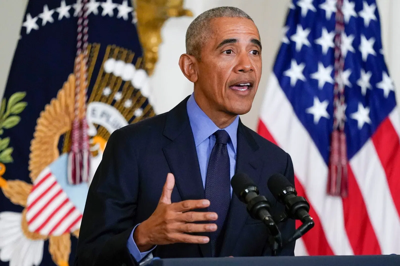

In [35]:
prompt = prompts[2]
instruction = prompt['prompt']['instruction']
image = Image.open(os.path.join(images_dir, prompt['image'])).convert('RGB')
print(instruction)
image.resize((image.size[0] // 4, image.size[1] // 4))

OBJ0 = SEG(image=IMAGE)
OBJ1 = SELECT(image=IMAGE, object=OBJ0, query='Barack Obama', category='person')
IMAGE0 = COLORPOP(image=IMAGE, object=OBJ1)
FINAL_RESULT = RESULT(var=IMAGE0)


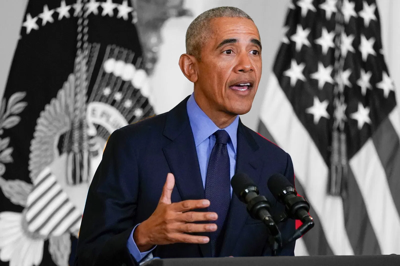

In [37]:
program = prompt['programs'][0]
print(program)
steps, result = do_imgedit_or_gqa(image, program)
result.output['var'].resize((image.size[0] // 4, image.size[1] // 4))

In [38]:
result.output['var'].save(os.path.join(images_dir, f'{prompt["id"]}_result0.png'))

'OBJ0 = SEG(image=IMAGE)'

'wall'

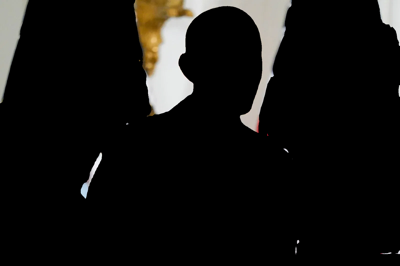

'person'

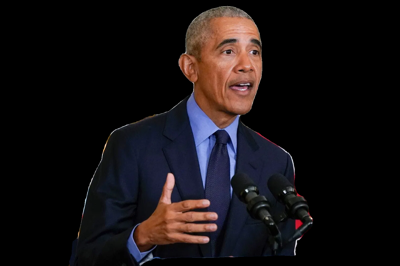

'base, pedestal, stand'

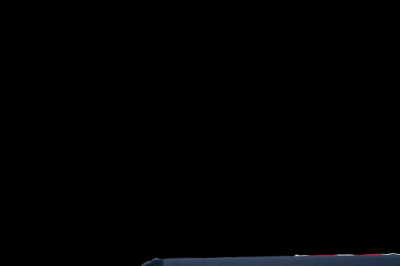

'flag'

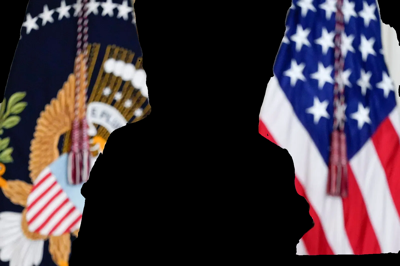

In [40]:
labels = [select.category_id_to_name[x] for x in np.unique(result.state['OBJ0'])]
display(steps[0], *sum([[label, i.resize((image.size[0] // 4, image.size[1] // 4))] for label, i in zip(labels, result.step_details[0]['output'])], []))

OBJ1 = SELECT(image=IMAGE, object=OBJ0, query='Barack Obama', category='person')


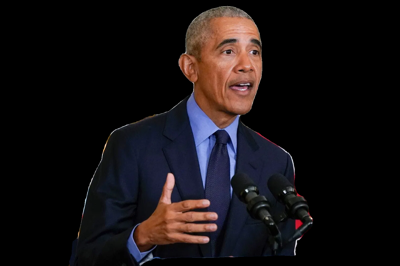

In [41]:
print(steps[1])
result.step_details[1]['output'].resize((image.size[0] // 4, image.size[1] // 4))

IMAGE0 = COLORPOP(image=IMAGE, object=OBJ1)


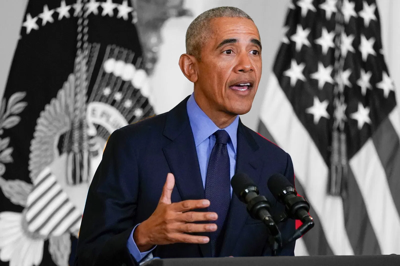

In [42]:
print(steps[2])
result.step_details[2]['output'].resize((image.size[0] // 4, image.size[1] // 4))

In [43]:
with open('assets/fig1/gqa_prompts.yaml', 'r') as f:
  prompts = yaml.safe_load(f)

Are there both ties and glasses in the picture?


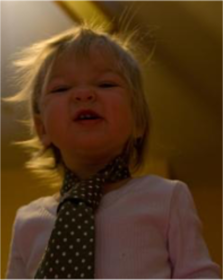

In [46]:
prompt = prompts[0]
question = prompt['prompt']['question']
image = Image.open(os.path.join(images_dir, prompt['image'])).convert('RGB')
print(question)
image.resize((image.size[0] // 2, image.size[1] // 2))

In [48]:
program = prompt['programs'][0]
print(program)
steps, result = do_imgedit_or_gqa(image, program)
result.output['var']

BOX0=LOC(image=IMAGE,object='tie')
BOX1=LOC(image=IMAGE,object='glasses')
ANSWER0=COUNT(box=BOX0)
ANSWER1=COUNT(box=BOX1)
ANSWER2=EVAL(expr="'yes' if {ANSWER0} > 0 and {ANSWER1} > 0 else 'no'")
FINAL_RESULT=RESULT(var=ANSWER2)


'no'

BOX0=LOC(image=IMAGE,object='tie')


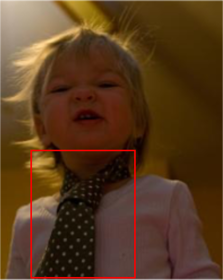

In [50]:
print(steps[0])
result.step_details[0]['image_with_bbox'].resize((image.size[0] // 2, image.size[1] // 2))

BOX1=LOC(image=IMAGE,object='glasses')


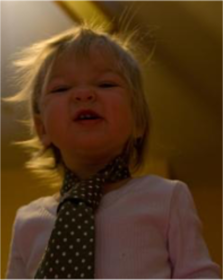

In [51]:
print(steps[1])
result.step_details[1]['image_with_bbox'].resize((image.size[0] // 2, image.size[1] // 2))

In [54]:
print(steps[2])
result.step_details[2]['text']

ANSWER0=COUNT(box=BOX0)


'The number of boxes is 1'

In [55]:
print(steps[3])
result.step_details[3]['text']

ANSWER1=COUNT(box=BOX1)


'The number of boxes is 0'

In [56]:
print(steps[4])
result.step_details[4]['output']

ANSWER2=EVAL(expr="'yes' if {ANSWER0} > 0 and {ANSWER1} > 0 else 'no'")


'no'

In [57]:
with open('assets/fig1/nlvr_prompts.yaml', 'r') as f:
  prompts = yaml.safe_load(f)

The left and right image contains a total of six people and two boats


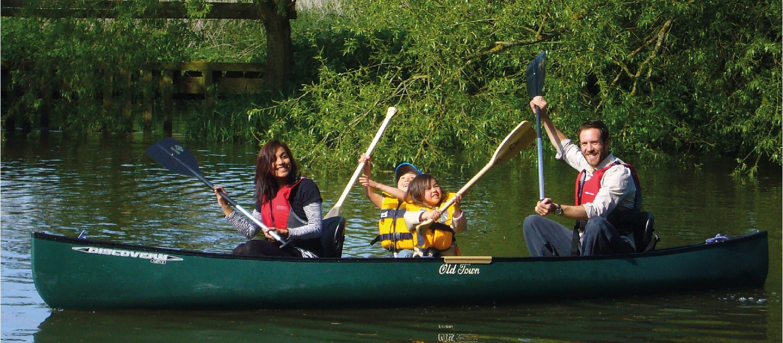

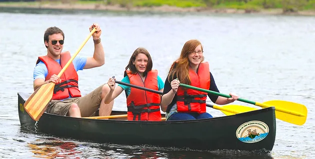

In [64]:
prompt = prompts[0]
statement = prompt['prompt']['statement']
left_image = Image.open(os.path.join(images_dir, prompt['pairs'][0]['left_image'])).convert('RGB')
right_image = Image.open(os.path.join(images_dir, prompt['pairs'][0]['right_image'])).convert('RGB')
print(statement)
display(left_image.resize((left_image.size[0] // 2, left_image.size[1] // 2)), right_image.resize((right_image.size[0] // 2, right_image.size[1] // 2)))

In [62]:
program = prompt['programs'][0]
print(program)
steps, result = do_nlvr(left_image, right_image, program)
result.output['var']

ANSWER0=VQA(image=LEFT,question='How many people are in the image?')
ANSWER1=VQA(image=RIGHT,question='How many people are in the image?')
ANSWER2=VQA(image=LEFT,question='How many boats are in the image?')
ANSWER3=VQA(image=RIGHT,question='How many boats are in the image?')
ANSWER4=EVAL(expr='{ANSWER0} + {ANSWER1} == 6')
ANSWER5=EVAL(expr='{ANSWER2} + {ANSWER3} == 2')
ANSWER6=EVAL(expr='{ANSWER4} and {ANSWER5}')
FINAL_ANSWER=RESULT(var=ANSWER6)


False

In [63]:
print(steps[0])
result.step_details[0]['output']

ANSWER0=VQA(image=LEFT,question='How many people are in the image?')


4

In [65]:
print(steps[1])
result.step_details[1]['output']

ANSWER1=VQA(image=RIGHT,question='How many people are in the image?')


3

In [66]:
print(steps[2])
result.step_details[2]['output']

ANSWER2=VQA(image=LEFT,question='How many boats are in the image?')


1

In [67]:
print(steps[3])
result.step_details[3]['output']

ANSWER3=VQA(image=RIGHT,question='How many boats are in the image?')


1

In [68]:
print(steps[4])
result.step_details[4]['output']

ANSWER4=EVAL(expr='{ANSWER0} + {ANSWER1} == 6')


False

In [69]:
print(steps[5])
result.step_details[5]['output']

ANSWER5=EVAL(expr='{ANSWER2} + {ANSWER3} == 2')


True

In [70]:
print(steps[6])
result.step_details[6]['output']

ANSWER6=EVAL(expr='{ANSWER4} and {ANSWER5}')


False